In [1]:
%pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


             DGS10        SP500          ret           dy       vol_21
count  2475.000000  2475.000000  2475.000000  2475.000000  2475.000000
mean      2.692198  3768.365778     0.000520     0.000848     0.009487
std       1.175237  1277.637857     0.011479     0.053609     0.006616
min       0.520000  1829.080000    -0.127652    -0.300000     0.002107
25%       1.730000  2715.045000    -0.003591    -0.030000     0.005586
50%       2.550000  3690.010000     0.000761     0.000000     0.007769
75%       3.845000  4512.325000     0.005793     0.030000     0.011811
max       4.980000  6901.000000     0.090895     0.290000     0.061454


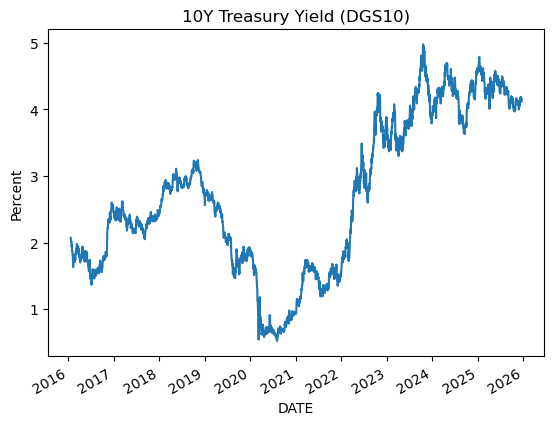

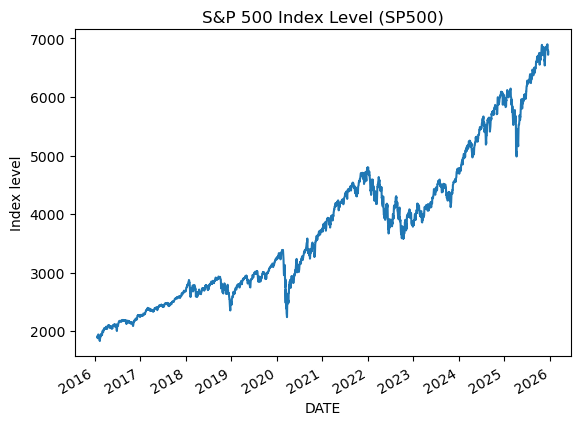

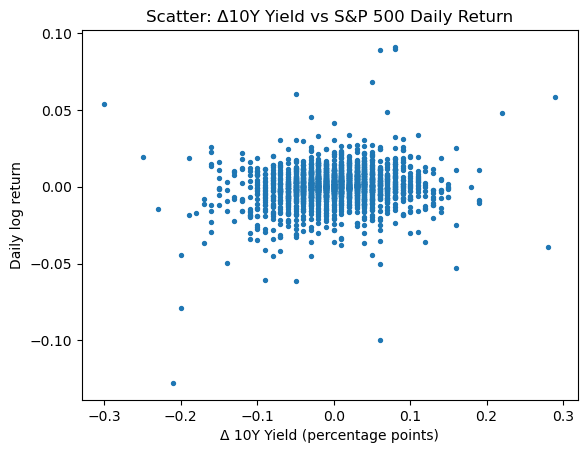

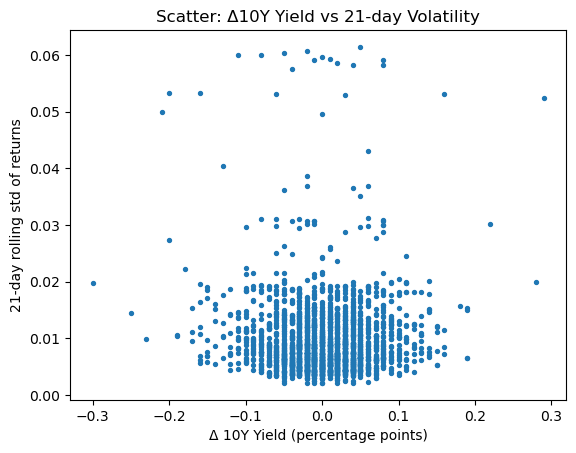

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     52.08
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           7.06e-13
Time:                        22:44:24   Log-Likelihood:                 7570.8
No. Observations:                2475   AIC:                        -1.514e+04
Df Residuals:                    2473   BIC:                        -1.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.164      0.0

In [2]:
# ====== 0) Install if needed ======
# pip install pandas pandas_datareader statsmodels matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data as web
import statsmodels.api as sm

# ====== 1) Load data from FRED ======
start = "2010-01-01"
end = None  # None = up to latest available

series = ["DGS10", "SP500"]  # 10Y yield, S&P 500 index level
df = web.DataReader(series, "fred", start, end)

# ====== 2) Clean & align ======
# DGS10 has missing on holidays; SP500 too. We'll drop rows with missing.
df = df.dropna().copy()

# ====== 3) Feature engineering ======
df["log_sp"] = np.log(df["SP500"])
df["ret"] = df["log_sp"].diff()         # daily log return
df["dy"] = df["DGS10"].diff()           # daily change in yield (percentage points)

# rolling volatility (21 trading days ~ 1 month)
df["vol_21"] = df["ret"].rolling(21).std()

df = df.dropna().copy()

# ====== 4) Quick EDA ======
print(df[["DGS10", "SP500", "ret", "dy", "vol_21"]].describe())

# ====== 5) Visualizations ======
plt.figure()
df["DGS10"].plot(title="10Y Treasury Yield (DGS10)")
plt.ylabel("Percent")
plt.show()

plt.figure()
df["SP500"].plot(title="S&P 500 Index Level (SP500)")
plt.ylabel("Index level")
plt.show()

plt.figure()
plt.scatter(df["dy"], df["ret"], s=8)
plt.title("Scatter: Δ10Y Yield vs S&P 500 Daily Return")
plt.xlabel("Δ 10Y Yield (percentage points)")
plt.ylabel("Daily log return")
plt.show()

plt.figure()
plt.scatter(df["dy"], df["vol_21"], s=8)
plt.title("Scatter: Δ10Y Yield vs 21-day Volatility")
plt.xlabel("Δ 10Y Yield (percentage points)")
plt.ylabel("21-day rolling std of returns")
plt.show()

# ====== 6) Regression: returns on yield changes ======
X = sm.add_constant(df["dy"])
y = df["ret"]
model_ret = sm.OLS(y, X).fit()
print(model_ret.summary())

# ====== 7) Regression: volatility on yield changes ======
X2 = sm.add_constant(df["dy"])
y2 = df["vol_21"]
model_vol = sm.OLS(y2, X2).fit()
print(model_vol.summary())

# ====== 8) Robustness: weekly frequency ======
weekly = df.resample("W-FRI").last().dropna().copy()
weekly["ret_w"] = weekly["log_sp"].diff()
weekly["dy_w"] = weekly["DGS10"].diff()
weekly["vol_4"] = weekly["ret_w"].rolling(4).std()  # ~1 month in weeks
weekly = weekly.dropna()

Xw = sm.add_constant(weekly["dy_w"])
mw_ret = sm.OLS(weekly["ret_w"], Xw).fit()
print("\nWeekly regression (return):")
print(mw_ret.summary())

mw_vol = sm.OLS(weekly["vol_4"], Xw).fit()
print("\nWeekly regression (volatility):")
print(mw_vol.summary())